In [13]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time
import matplotlib.pyplot as plt
from google.colab import drive

In [14]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!ls "/content/drive/My Drive/Deep Learning"

 1.jpg			  fashion-mnist_train.csv   train.csv
 2.jpg			  flowers-Recognition	   'Untitled0 (1).ipynb'
 3.jpg			  Housing.CSV		    Untitled0.ipynb
'Cat and Dog'		  insurance.csv		    win2.xls
 cifar-10-batches-py	  mnist_test.csv	    wine1.xls
 creditcard.csv		  mnist_train.csv
 fashion-mnist_test.csv   test.csv


In [16]:
data_dir = "/content/drive/My Drive/Deep Learning/Cat and Dog/"

train_transforms = transforms.Compose([transforms.RandomRotation(35),
                                       transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
                                       transforms.ColorJitter(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in data
train_data = datasets.ImageFolder(data_dir + '/training_set/training_set', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test_set/test_set', transform=test_transforms)

# Load train and test loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

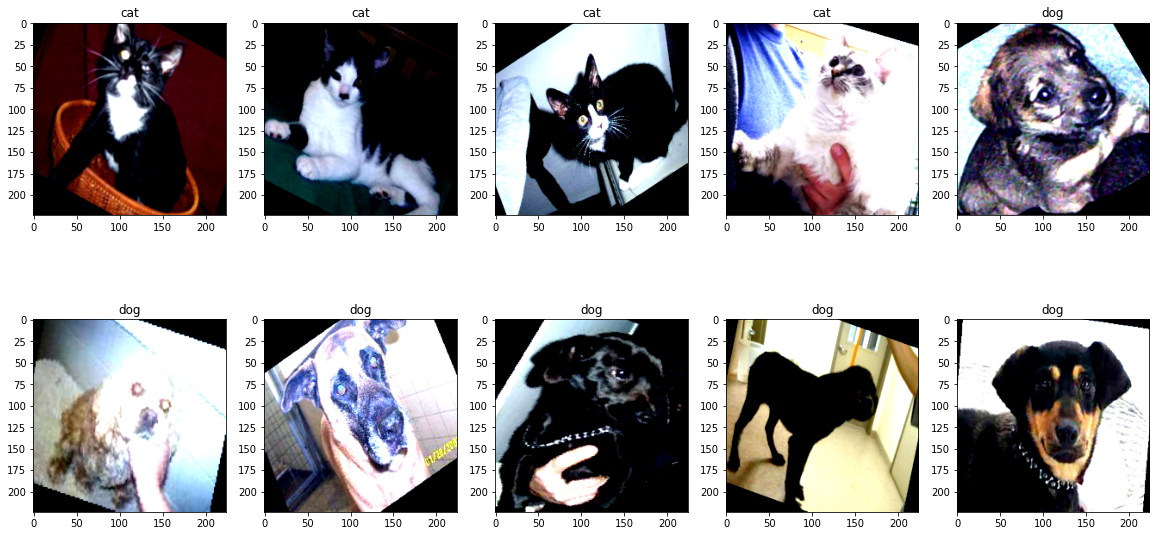

In [17]:
def image_convert(img):
    img = img.clone().cpu().numpy()
    img = img.transpose(1,2,0)
    std = [0.5,0.5,0.5]
    mean = [0.5,0.5,0.5]
    img = img*std + mean
    return img


def plot_10():
        iter_ = iter(trainloader)
        images,labels = next(iter_)
        an_ = {'0':'cat','1':'dog'}
        
        plt.figure(figsize=(20,10))
        for idx in range(10):
            plt.subplot(2,5,idx+1)
            img = image_convert(images[idx])
            label = labels[idx]
            plt.imshow(img)
            plt.title(an_[str(label.numpy())])
        plt.show()
        
plot_10()

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [19]:
# Load ResNet50 pretrained model
model = models.resnet50(pretrained=True)

# Turn off gradients for our model
# Avoid gradiente descent again
for param in model.parameters():
    param.requires_grad = False

# Define a new classifier to our cat and dog data
# Starts with 2048 because it's a requirement of ResNet
classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(512, 256),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(256, 2),
                           nn.LogSoftmax(dim=1))

# Change model classifier
model.fc = classifier



## **Adam Optimizer**

In [20]:
# Criterion function
criterion = nn.NLLLoss()

# Set optimizer and learning rate
optimizer = optim.Adam(model.fc.parameters(), amsgrad=True)

# Send model to GPU
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
# Train and validate our model

# Explain the model
print('Model: Resnet50 + 3 Layers + Dropout 0.2')
print('Criterion: NLLLoss / Optimizer: Adam')

# Set controls
epochs = 10
running_loss = 0
test_loss = 0
accuracy = 0 

# Run epochs
for epoch in range(epochs):
  
    start_time = time.time()
    
    # Train loop    
    for images, labels in trainloader:        
        # Move input and label tensors to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Get log probabilities
        logps = model(images)
        # Get loss from criterion
        loss = criterion(logps, labels)
        # Backward pass loss
        loss.backward()
        # Optimizer step
        optimizer.step()
        
        # Keeping track on loss
        running_loss += loss.item()
        
    # Put model in evaluation mode
    model.eval()
        
    # Stops gradient descent
    with torch.no_grad():
        # Run a test loop and get accuracy of our model
        for images, labels in testloader:
            # Move input and label tensors to GPU
            images, labels = images.to(device), labels.to(device)
            
            # Get log probabilities
            logps = model(images)
            # Get loss from criterion
            loss = criterion(logps, labels)
            # Keeping track on testing loss
            test_loss += loss.item()
            
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            
    print(f'Epoch {epoch+1}/{epochs}.. '
          f'Train loss: {running_loss/len(trainloader):.3f}.. '
          f'Test loss: {test_loss/len(testloader):.3f}.. '
          f'Test accuracy: {accuracy/len(testloader):.3f}')
            
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
    # Reset controls
    running_loss = 0        
    test_loss = 0
    accuracy = 0            
    
    # Put model back in training mode
    model.train()

Model: Resnet50 + 3 Layers + Dropout 0.2
Criterion: NLLLoss / Optimizer: Adam
Epoch 1/10.. Train loss: 0.138.. Test loss: 0.060.. Test accuracy: 0.978
00:01:36
Epoch 2/10.. Train loss: 0.080.. Test loss: 0.110.. Test accuracy: 0.960
00:01:35
Epoch 3/10.. Train loss: 0.086.. Test loss: 0.085.. Test accuracy: 0.971
00:01:35
Epoch 4/10.. Train loss: 0.083.. Test loss: 0.039.. Test accuracy: 0.985
00:01:35
Epoch 5/10.. Train loss: 0.083.. Test loss: 0.092.. Test accuracy: 0.954
00:01:35
Epoch 6/10.. Train loss: 0.085.. Test loss: 0.053.. Test accuracy: 0.978
00:01:35
Epoch 7/10.. Train loss: 0.062.. Test loss: 0.046.. Test accuracy: 0.983
00:01:35
Epoch 8/10.. Train loss: 0.063.. Test loss: 0.050.. Test accuracy: 0.983
00:01:35
Epoch 9/10.. Train loss: 0.070.. Test loss: 0.040.. Test accuracy: 0.986
00:01:35
Epoch 10/10.. Train loss: 0.068.. Test loss: 0.041.. Test accuracy: 0.987
00:01:35


## **Adadelta Optimizer**

In [23]:
# Criterion function
criterion = nn.NLLLoss()

# Set optimizer and learning rate
optimizer = optim.Adadelta(model.fc.parameters())

# Send model to GPU
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# Train and validate our model

# Explain the model
print('Model: Resnet50 + 3 Layers + Dropout 0.2')
print('Criterion: NLLLoss / Optimizer: Adam')

# Set controls
epochs = 10
running_loss = 0
test_loss = 0
accuracy = 0 

# Run epochs
for epoch in range(epochs):
  
    start_time = time.time()
    
    # Train loop    
    for images, labels in trainloader:        
        # Move input and label tensors to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Get log probabilities
        logps = model(images)
        # Get loss from criterion
        loss = criterion(logps, labels)
        # Backward pass loss
        loss.backward()
        # Optimizer step
        optimizer.step()
        
        # Keeping track on loss
        running_loss += loss.item()
        
    # Put model in evaluation mode
    model.eval()
        
    # Stops gradient descent
    with torch.no_grad():
        # Run a test loop and get accuracy of our model
        for images, labels in testloader:
            # Move input and label tensors to GPU
            images, labels = images.to(device), labels.to(device)
            
            # Get log probabilities
            logps = model(images)
            # Get loss from criterion
            loss = criterion(logps, labels)
            # Keeping track on testing loss
            test_loss += loss.item()
            
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            
    print(f'Epoch {epoch+1}/{epochs}.. '
          f'Train loss: {running_loss/len(trainloader):.3f}.. '
          f'Test loss: {test_loss/len(testloader):.3f}.. '
          f'Test accuracy: {accuracy/len(testloader):.3f}')
            
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
    # Reset controls
    running_loss = 0        
    test_loss = 0
    accuracy = 0            
    
    # Put model back in training mode
    model.train()

Model: Resnet50 + 3 Layers + Dropout 0.2
Criterion: NLLLoss / Optimizer: Adam
Epoch 1/10.. Train loss: 0.071.. Test loss: 0.355.. Test accuracy: 0.904
00:01:37
Epoch 2/10.. Train loss: 0.083.. Test loss: 0.225.. Test accuracy: 0.912
00:01:35
Epoch 3/10.. Train loss: 0.069.. Test loss: 0.192.. Test accuracy: 0.943
00:01:35
Epoch 4/10.. Train loss: 0.067.. Test loss: 0.038.. Test accuracy: 0.988
00:01:35
Epoch 5/10.. Train loss: 0.060.. Test loss: 0.041.. Test accuracy: 0.988
00:01:35
Epoch 6/10.. Train loss: 0.062.. Test loss: 0.045.. Test accuracy: 0.984
00:01:35
Epoch 7/10.. Train loss: 0.069.. Test loss: 0.107.. Test accuracy: 0.947
00:01:35
Epoch 8/10.. Train loss: 0.056.. Test loss: 0.039.. Test accuracy: 0.989
00:01:35
Epoch 9/10.. Train loss: 0.059.. Test loss: 0.039.. Test accuracy: 0.990
00:01:35
Epoch 10/10.. Train loss: 0.049.. Test loss: 0.059.. Test accuracy: 0.978
00:01:35


## **RMSprop Optimizer**

In [26]:
# Criterion function
criterion = nn.NLLLoss()

# Set optimizer and learning rate
optimizer = optim.RMSprop(model.fc.parameters())

# Send model to GPU
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
# Train and validate our model

# Explain the model
print('Model: Resnet50 + 3 Layers + Dropout 0.2')
print('Criterion: NLLLoss / Optimizer: Adam')

# Set controls
epochs = 10
running_loss = 0
test_loss = 0
accuracy = 0 

# Run epochs
for epoch in range(epochs):
  
    start_time = time.time()
    
    # Train loop    
    for images, labels in trainloader:        
        # Move input and label tensors to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Get log probabilities
        logps = model(images)
        # Get loss from criterion
        loss = criterion(logps, labels)
        # Backward pass loss
        loss.backward()
        # Optimizer step
        optimizer.step()
        
        # Keeping track on loss
        running_loss += loss.item()
        
    # Put model in evaluation mode
    model.eval()
        
    # Stops gradient descent
    with torch.no_grad():
        # Run a test loop and get accuracy of our model
        for images, labels in testloader:
            # Move input and label tensors to GPU
            images, labels = images.to(device), labels.to(device)
            
            # Get log probabilities
            logps = model(images)
            # Get loss from criterion
            loss = criterion(logps, labels)
            # Keeping track on testing loss
            test_loss += loss.item()
            
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            
    print(f'Epoch {epoch+1}/{epochs}.. '
          f'Train loss: {running_loss/len(trainloader):.3f}.. '
          f'Test loss: {test_loss/len(testloader):.3f}.. '
          f'Test accuracy: {accuracy/len(testloader):.3f}')
            
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
    # Reset controls
    running_loss = 0        
    test_loss = 0
    accuracy = 0            
    
    # Put model back in training mode
    model.train()

Model: Resnet50 + 3 Layers + Dropout 0.2
Criterion: NLLLoss / Optimizer: Adam
Epoch 1/10.. Train loss: 203.038.. Test loss: 0.059.. Test accuracy: 0.976
00:01:36
Epoch 2/10.. Train loss: 0.307.. Test loss: 0.052.. Test accuracy: 0.985
00:01:34
Epoch 3/10.. Train loss: 0.994.. Test loss: 0.704.. Test accuracy: 0.498
00:01:34
Epoch 4/10.. Train loss: 0.881.. Test loss: 0.175.. Test accuracy: 0.959
00:01:34
Epoch 5/10.. Train loss: 0.219.. Test loss: 0.098.. Test accuracy: 0.980
00:01:35
Epoch 6/10.. Train loss: 0.481.. Test loss: 0.085.. Test accuracy: 0.982
00:01:35
Epoch 7/10.. Train loss: 3.384.. Test loss: 0.069.. Test accuracy: 0.973
00:01:34
Epoch 8/10.. Train loss: 0.140.. Test loss: 0.163.. Test accuracy: 0.969
00:01:35
Epoch 9/10.. Train loss: 0.117.. Test loss: 0.051.. Test accuracy: 0.983
00:01:35
Epoch 10/10.. Train loss: 0.215.. Test loss: 7.027.. Test accuracy: 0.500
00:01:35


## **SGD Optimizer**

In [29]:
# Criterion function
criterion = nn.NLLLoss()

# Set optimizer and learning rate
optimizer = optim.SGD(model.fc.parameters(),lr=0.1)

# Send model to GPU
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
# Train and validate our model

# Explain the model
print('Model: Resnet50 + 3 Layers + Dropout 0.2')
print('Criterion: NLLLoss / Optimizer: Adam')

# Set controls
epochs = 10
running_loss = 0
test_loss = 0
accuracy = 0 

# Run epochs
for epoch in range(epochs):
  
    start_time = time.time()
    
    # Train loop    
    for images, labels in trainloader:        
        # Move input and label tensors to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Get log probabilities
        logps = model(images)
        # Get loss from criterion
        loss = criterion(logps, labels)
        # Backward pass loss
        loss.backward()
        # Optimizer step
        optimizer.step()
        
        # Keeping track on loss
        running_loss += loss.item()
        
    # Put model in evaluation mode
    model.eval()
        
    # Stops gradient descent
    with torch.no_grad():
        # Run a test loop and get accuracy of our model
        for images, labels in testloader:
            # Move input and label tensors to GPU
            images, labels = images.to(device), labels.to(device)
            
            # Get log probabilities
            logps = model(images)
            # Get loss from criterion
            loss = criterion(logps, labels)
            # Keeping track on testing loss
            test_loss += loss.item()
            
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            
    print(f'Epoch {epoch+1}/{epochs}.. '
          f'Train loss: {running_loss/len(trainloader):.3f}.. '
          f'Test loss: {test_loss/len(testloader):.3f}.. '
          f'Test accuracy: {accuracy/len(testloader):.3f}')
            
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
    # Reset controls
    running_loss = 0        
    test_loss = 0
    accuracy = 0            
    
    # Put model back in training mode
    model.train()

Model: Resnet50 + 3 Layers + Dropout 0.2
Criterion: NLLLoss / Optimizer: Adam
Epoch 1/10.. Train loss: 5.033.. Test loss: 0.691.. Test accuracy: 0.504
00:01:35
Epoch 2/10.. Train loss: 0.738.. Test loss: 0.539.. Test accuracy: 0.498
00:01:34
Epoch 3/10.. Train loss: 0.846.. Test loss: 0.690.. Test accuracy: 0.506
00:01:34
Epoch 4/10.. Train loss: 0.660.. Test loss: 0.670.. Test accuracy: 0.535
00:01:35
Epoch 5/10.. Train loss: 0.715.. Test loss: 0.691.. Test accuracy: 0.514
00:01:34
Epoch 6/10.. Train loss: 0.688.. Test loss: 0.690.. Test accuracy: 0.504
00:01:34
Epoch 7/10.. Train loss: 0.686.. Test loss: 0.680.. Test accuracy: 0.522
00:01:34
Epoch 8/10.. Train loss: 0.653.. Test loss: 0.690.. Test accuracy: 0.522
00:01:35
Epoch 9/10.. Train loss: 0.659.. Test loss: 0.691.. Test accuracy: 0.499
00:01:34
Epoch 10/10.. Train loss: 0.587.. Test loss: 0.713.. Test accuracy: 0.503
00:01:34
